In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import matplotlib.pyplot as plt
import warnings

plt.style.use('seaborn')
# plt.style.use('seaborn-colorblind') #alternative
plt.rcParams['figure.figsize'] = [8, 4.5]
plt.rcParams['figure.dpi'] = 300
warnings.simplefilter(action='ignore', category=FutureWarning)

# Time Series Modeling

## Decomposing time series

### How to do it...

1. Import the libraries:

In [3]:
import pandas as pd
import quandl
from statsmodels.tsa.seasonal import seasonal_decompose

2. Download the prices of gold for years 2000-2011 and resample to monthly values:

In [4]:
QUANDL_KEY = '2NfuwGG8_oyV5Tj3Zr9k' # replace {key} with your own API key  
quandl.ApiConfig.api_key = QUANDL_KEY

df = quandl.get(dataset='WGC/GOLD_MONAVG_USD',
                start_date='2000-01-01', 
                end_date='2011-12-31')

df.rename(columns={'Value': 'price'}, inplace=True)
df = df.resample('M').last()

In [5]:
print(f'Shape of DataFrame: {df.shape}')
df.head().append(df.tail())

Shape of DataFrame: (144, 1)


,price
Date,
2000-01-31,284.31
2000-02-29,299.86
2000-03-31,286.39
2000-04-30,279.69
2000-05-31,275.19
2011-08-31,1755.81
2011-09-30,1771.85
2011-10-31,1665.21
2011-11-30,1738.98


3. Add rolling mean and standard deviation:

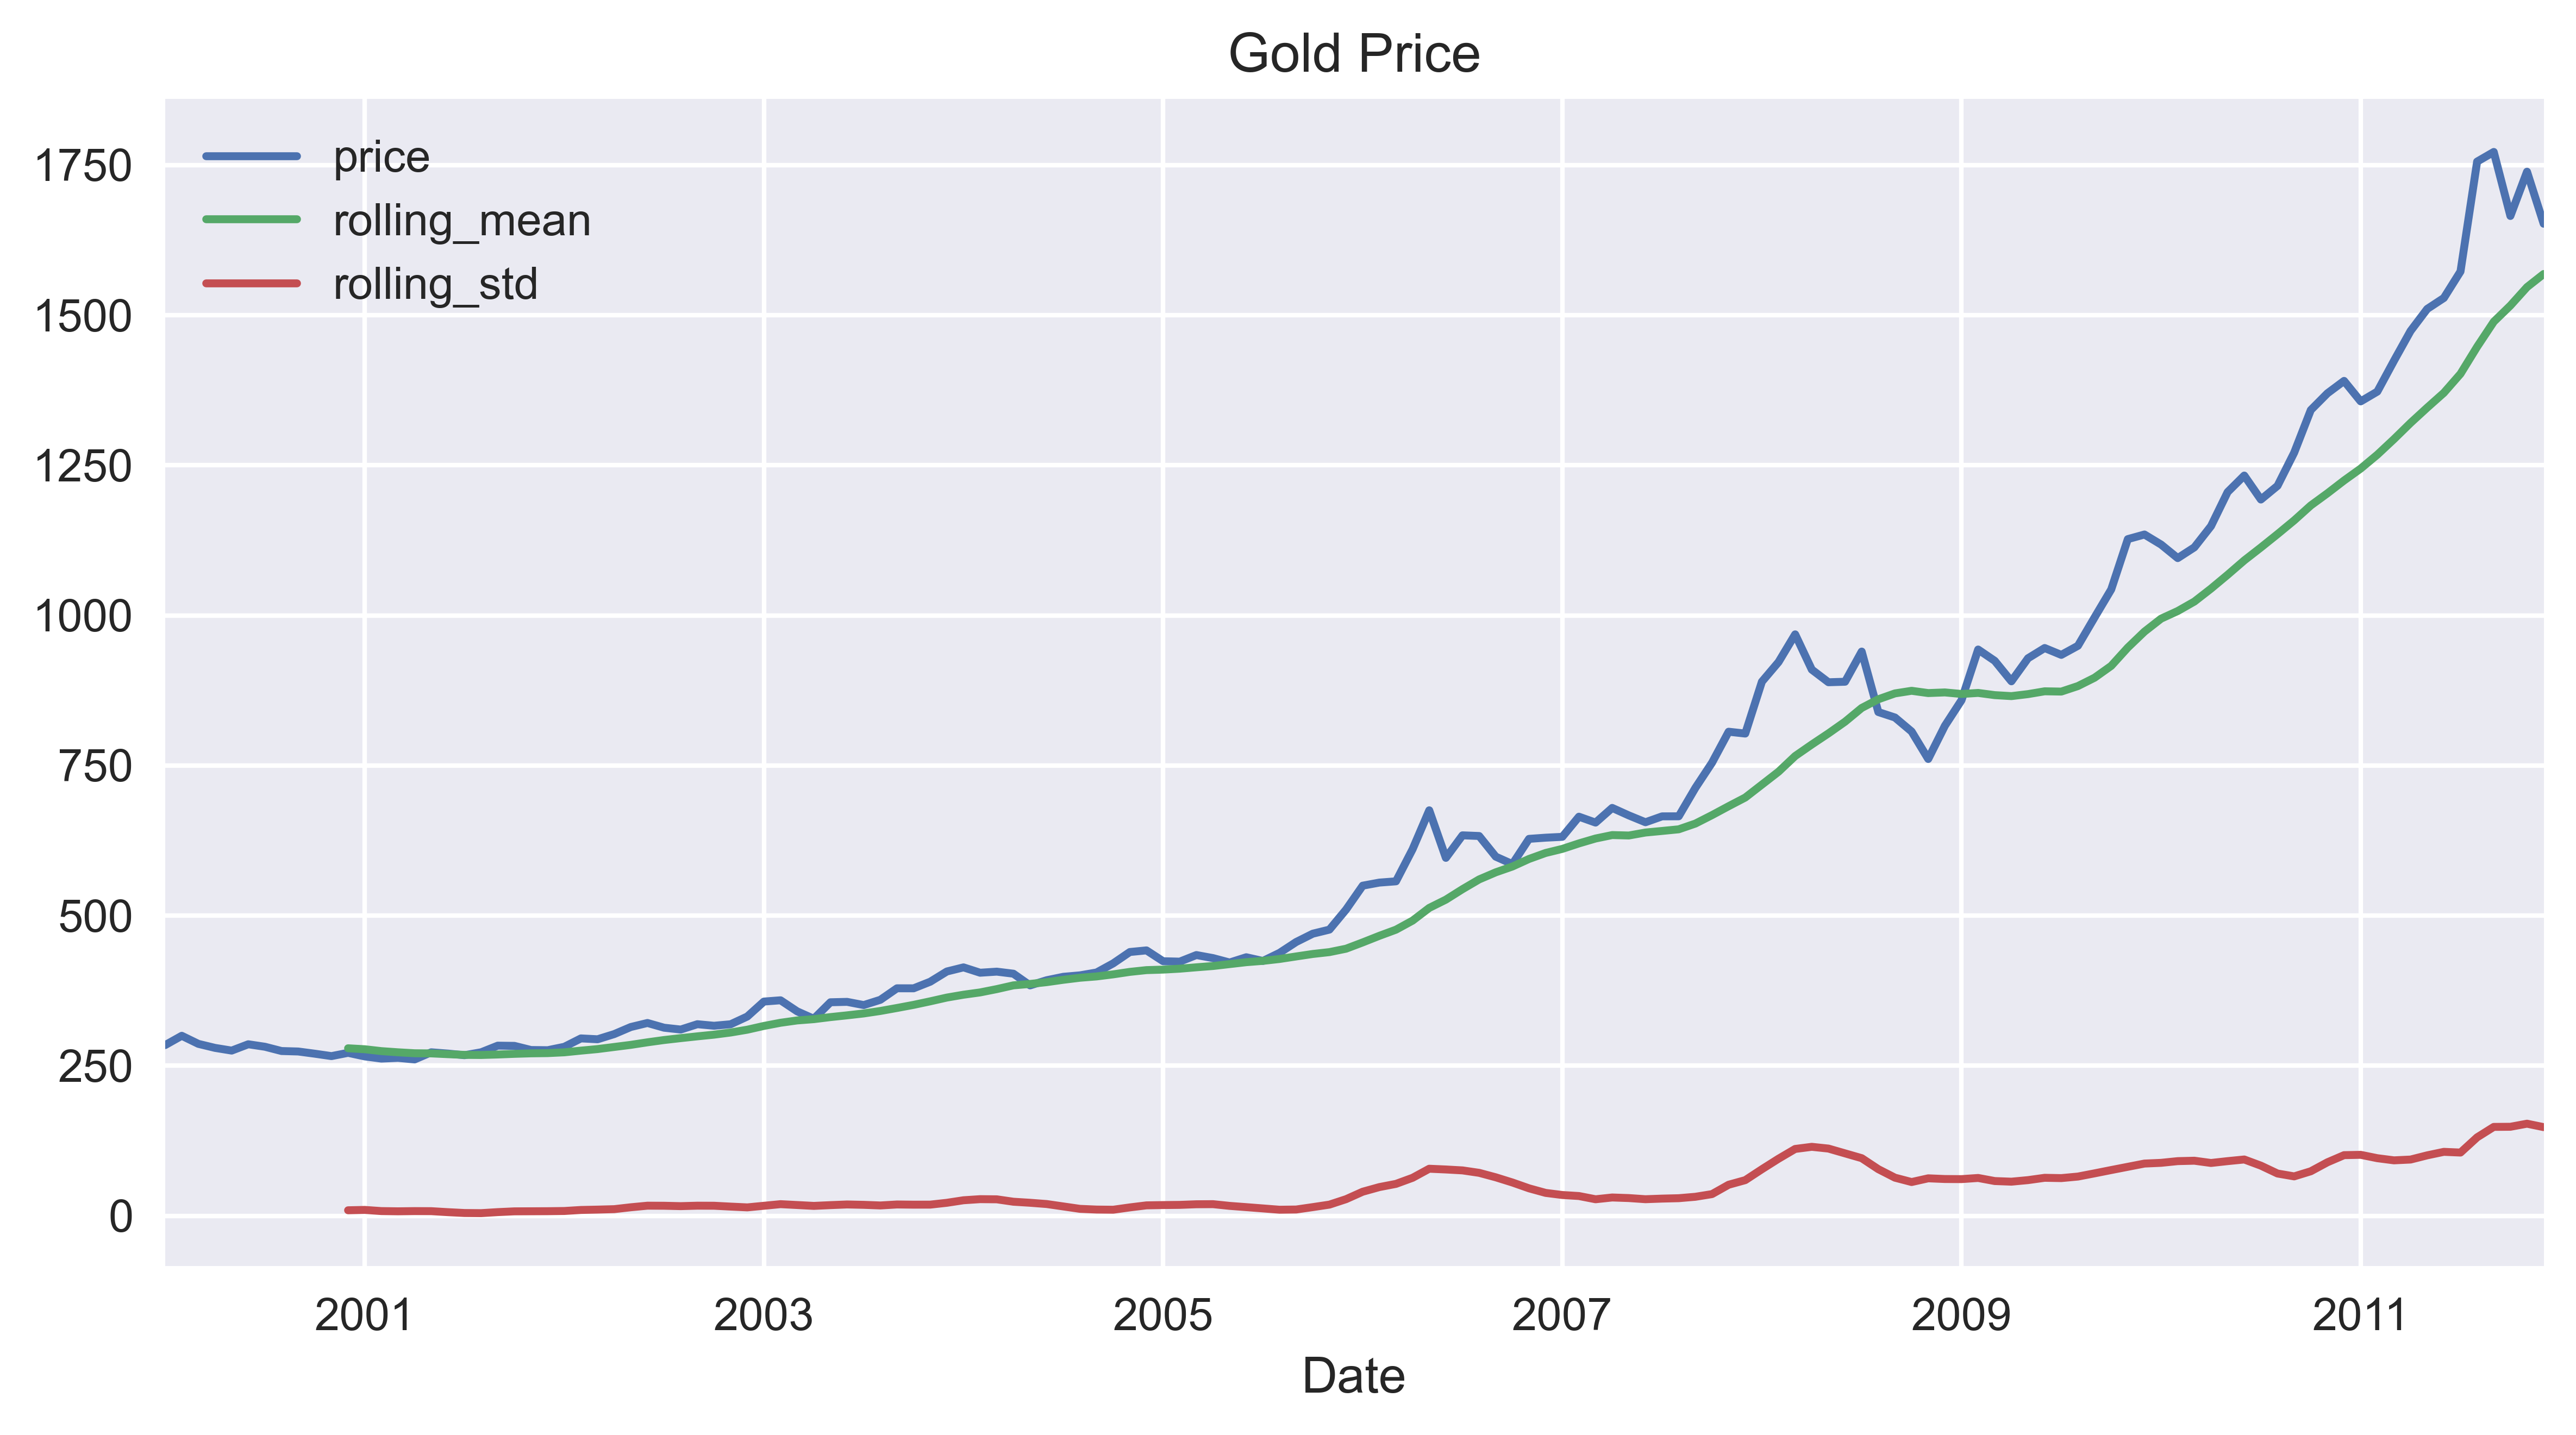

In [6]:
WINDOW_SIZE = 12
df['rolling_mean'] = df.price.rolling(window=WINDOW_SIZE).mean()
df['rolling_std'] = df.price.rolling(window=WINDOW_SIZE).std()
df.plot(title='Gold Price')

plt.tight_layout()
#plt.savefig('images/ch3_im1.png')
plt.show()

4. Carry out seasonal decomposition using the multiplicative model:

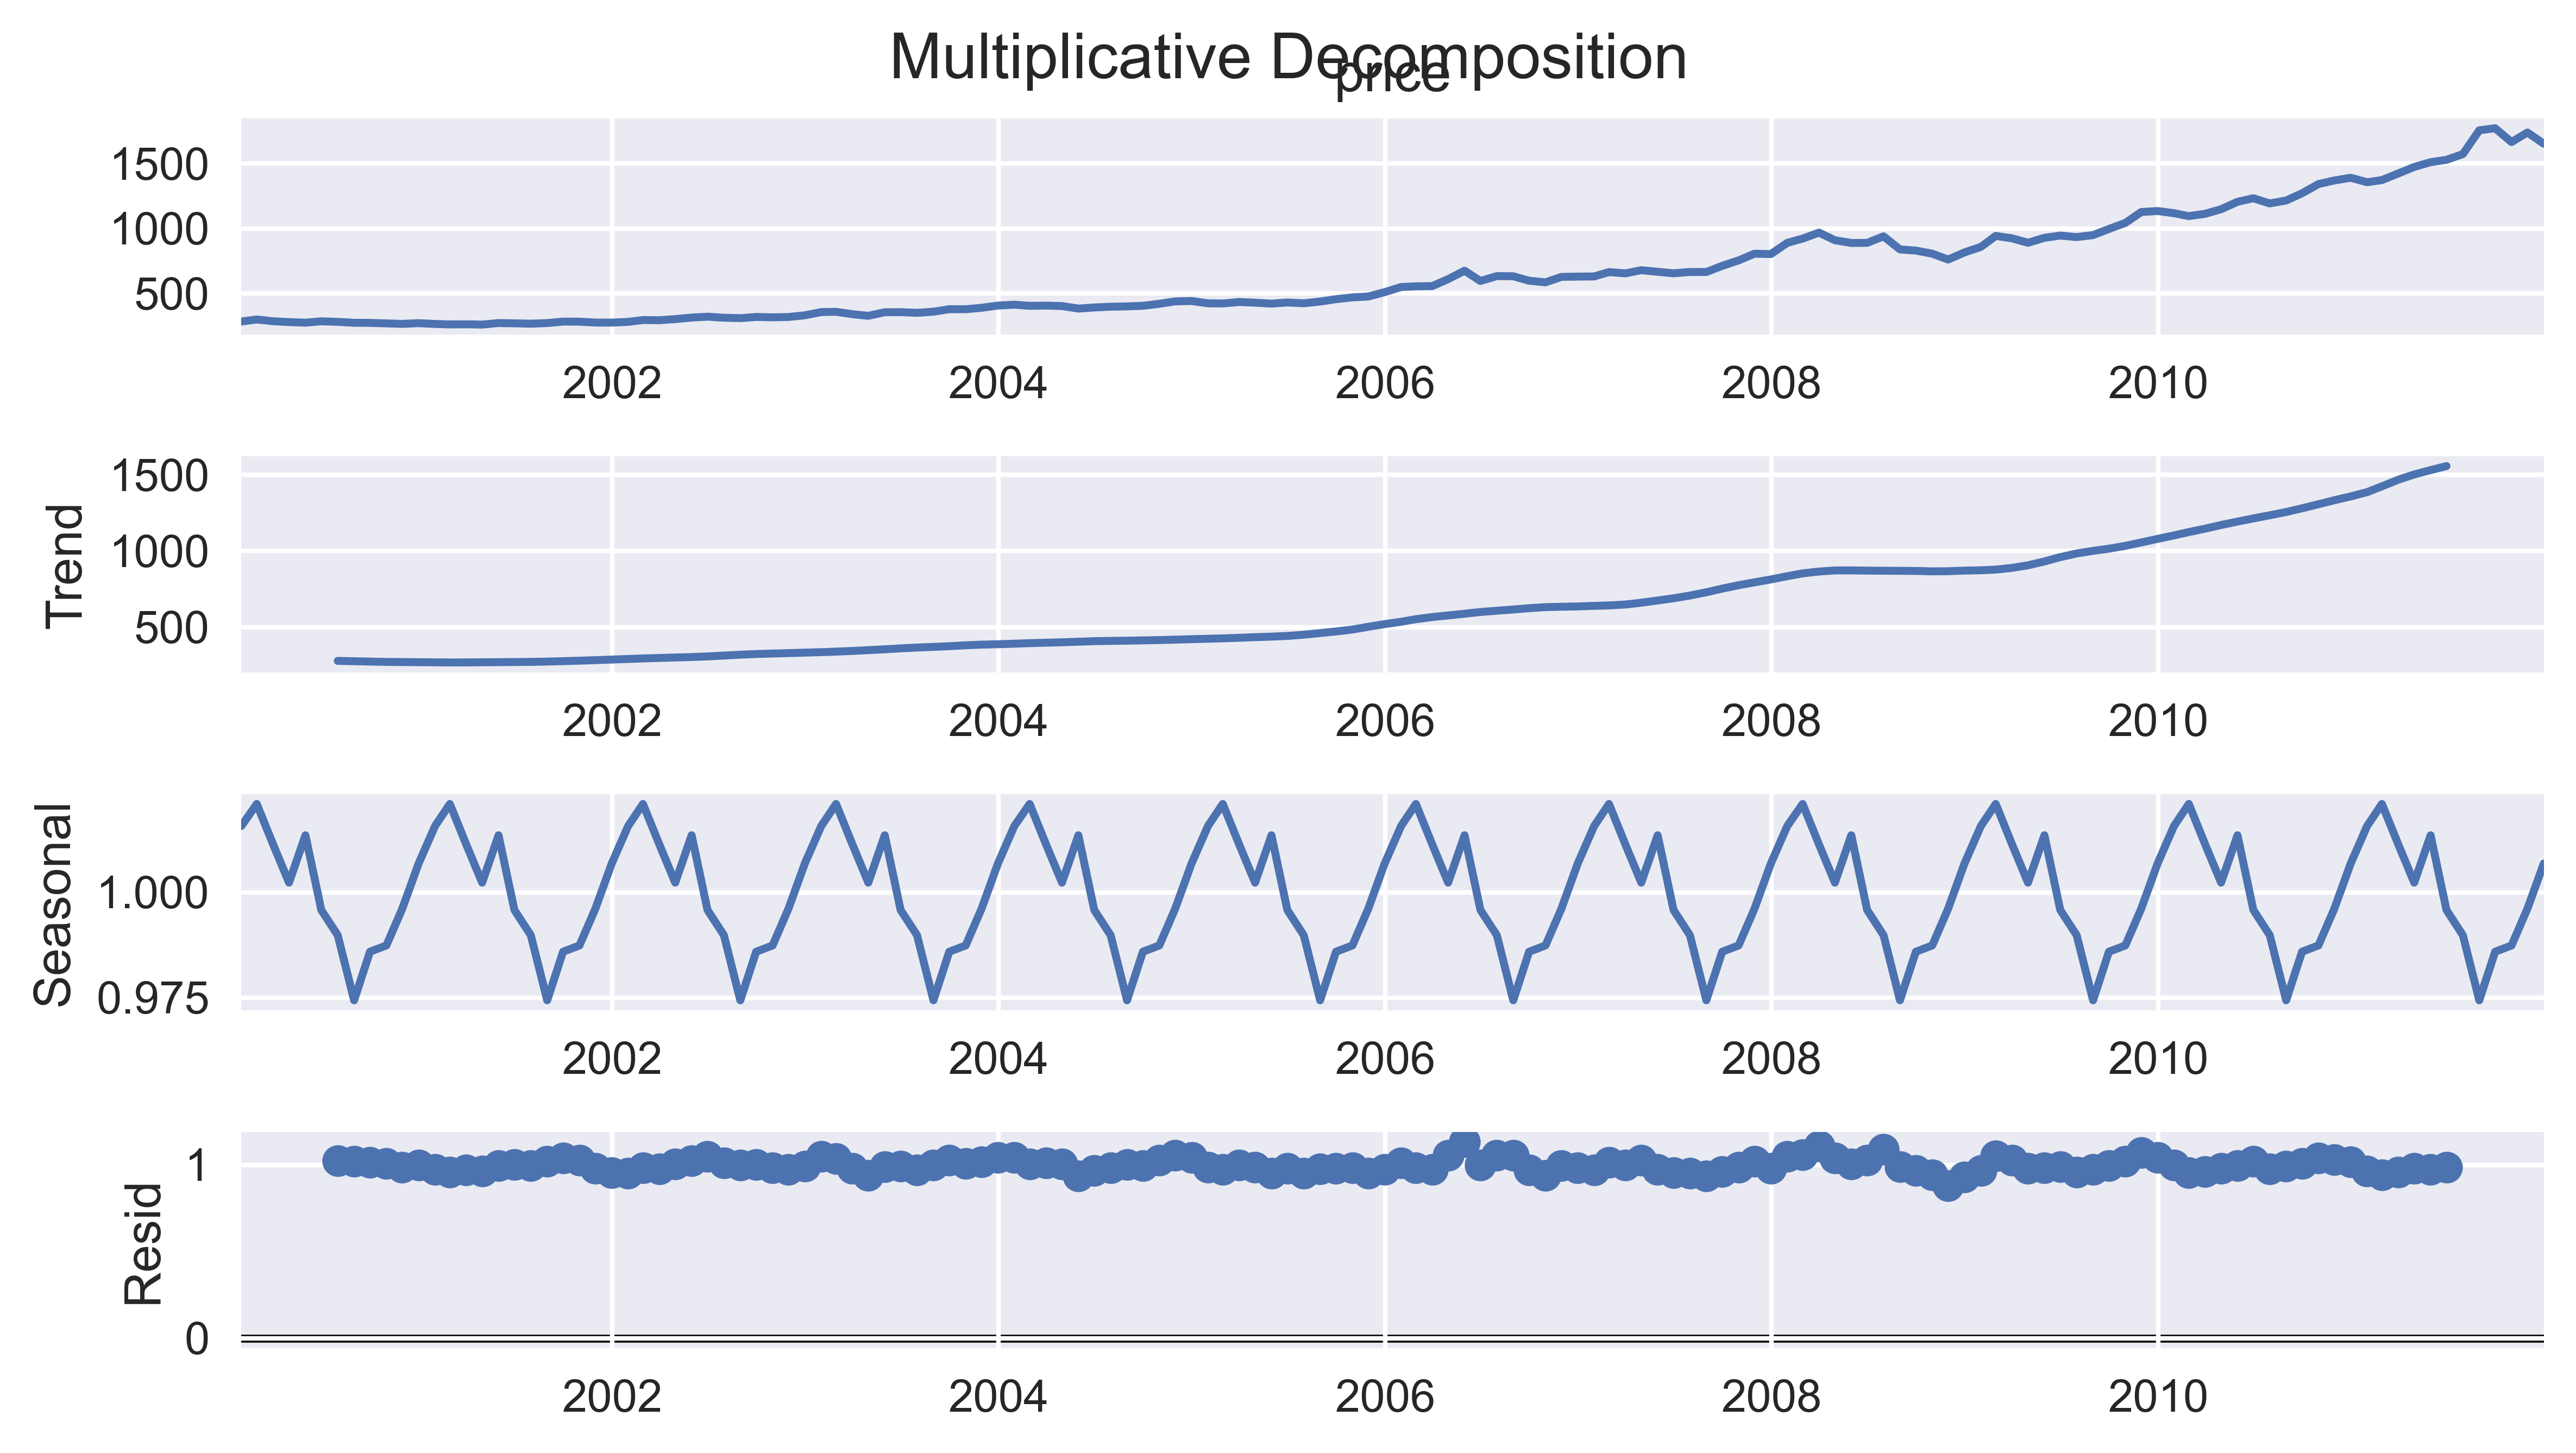

In [7]:
decomposition_results = seasonal_decompose(df.price, 
                                           model='multiplicative')
decomposition_results.plot() \
                     .suptitle('Multiplicative Decomposition', 
                               fontsize=14)

plt.tight_layout()
# plt.savefig('images/ch3_im2.png')
plt.show()

### Why has the above happened for the residuals?

## Decomposing time series using Facebook's Prophet

### Quick start guide for fbprophet

https://facebook.github.io/prophet/docs/quick_start.html

### How to do it...

1. Import the libraries and authenticate with Quandl:

In [8]:
import pandas as pd
import seaborn as sns
import quandl
from fbprophet import Prophet

quandl.ApiConfig.api_key = QUANDL_KEY

2. Download the daily gold prices and rename the columns:

In [9]:
df = quandl.get(dataset='WGC/GOLD_DAILY_USD',
                start_date='2000-01-01',
                end_date='2005-12-31')
df.head()

,Value
Date,
2000-01-03,290.25
2000-01-04,281.50
2000-01-05,280.45
2000-01-06,279.40
2000-01-07,282.10


In [10]:
df.reset_index(drop=False, inplace=True)
df.rename(columns={'Date': 'ds', 'Value': 'y'}, inplace=True)
df.head()

,ds,y
0,2000-01-03,290.25
1,2000-01-04,281.50
2,2000-01-05,280.45
3,2000-01-06,279.40
4,2000-01-07,282.10


3. Split the series into the training and test sets:

In [11]:
train_indices = df.ds.apply(lambda x: x.year).values < 2005
df_train = df.loc[train_indices].dropna()
df_test = df.loc[~train_indices].reset_index(drop=True)

In [12]:
df_test.head()

,ds,y
0,2005-01-03,435.60
1,2005-01-04,427.75
2,2005-01-05,426.00
3,2005-01-06,424.35
4,2005-01-07,422.20


4. Create the instance of the model and fit it to the data:

In [ ]:
model_prophet = Prophet(seasonality_mode='additive')
model_prophet.add_seasonality(name='monthly', period=30.5, fourier_order=5)
model_prophet.fit(df_train)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


5. Forecast the gold prices 1 year ahead and plot the results:

In [ ]:
df_future = model_prophet.make_future_dataframe(periods=365)
df_pred = model_prophet.predict(df_future)
model_prophet.plot(df_pred)

plt.tight_layout()
#plt.savefig('images/ch3_im3.png')
plt.show()

6. Inspect the decomposition of the time series:

In [ ]:
model_prophet.plot_components(df_pred)

plt.tight_layout()
#plt.savefig('images/ch3_im4.png')
plt.show()

### There's more...

1. Merge the test set with the forecasts:

In [ ]:
selected_columns = ['ds', 'yhat_lower', 'yhat_upper', 'yhat']

df_pred = df_pred.loc[:, selected_columns].reset_index(drop=True)
df_test = df_test.merge(df_pred, on=['ds'], how='left')
df_test.ds = pd.to_datetime(df_test.ds)
df_test.set_index('ds', inplace=True)

2. Plot the test values vs. predictions:

In [ ]:
fig, ax = plt.subplots(1, 1)

ax = sns.lineplot(data=df_test[['y', 'yhat_lower', 
                                'yhat_upper', 'yhat']])
ax.fill_between(df_test.index,
                df_test.yhat_lower,
                df_test.yhat_upper,
                alpha=0.3)
ax.set(title='Gold Price - actual vs. predicted',
       xlabel='Date',
       ylabel='Gold Price ($)')

plt.tight_layout()
#plt.savefig('images/ch3_im5.png')
plt.show()

## Testing for stationarity in time series

### How to do it...

0: Download the data:

In [ ]:
import pandas as pd
import quandl

In [ ]:
quandl.ApiConfig.api_key = QUANDL_KEY

df = quandl.get(dataset='WGC/GOLD_MONAVG_USD',
                start_date='2000-01-01', 
                end_date='2011-12-31')

df.rename(columns={'Value': 'price'}, inplace=True)
df = df.resample('M').last()

1. Import the libraries:

In [ ]:
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss

2. Define a function for running the ADF test:

In [ ]:
def adf_test(x):
    '''
    Function for performing the Augmented Dickey-Fuller test for stationarity
    
    Null Hypothesis: time series is not stationary
    Alternate Hypothesis: time series is stationary

    Parameters
    ----------
    x : pd.Series / np.array
        The time series to be checked for stationarity
    
    Returns
    -------
    results: pd.DataFrame
        A DataFrame with the ADF test's results
    '''
    
    indices = ['Test Statistic', 'p-value',
               '# of Lags Used', '# of Observations Used']
    
    adf_test = adfuller(x, autolag='AIC')
    results = pd.Series(adf_test[0:4], index=indices)
    
    for key, value in adf_test[4].items():
        results[f'Critical Value ({key})'] = value

    return results


In [ ]:
adf_test(df.price)

3. Define a function for running the KPSS test:

In [ ]:
def kpss_test(x, h0_type='c'):
    '''
    Function for performing the Kwiatkowski-Phillips-Schmidt-Shin test for stationarity

    Null Hypothesis: time series is stationary
    Alternate Hypothesis: time series is not stationary

    Parameters
    ----------
    x: pd.Series / np.array
        The time series to be checked for stationarity
    h0_type: str{'c', 'ct'}
        Indicates the null hypothesis of the KPSS test:
            * 'c': The data is stationary around a constant(default)
            * 'ct': The data is stationary around a trend
    
    Returns
    -------
    results: pd.DataFrame
        A DataFrame with the KPSS test's results
    '''
    
    indices = ['Test Statistic', 'p-value', '# of Lags']

    kpss_test = kpss(x, regression=h0_type)
    results = pd.Series(kpss_test[0:3], index=indices)
    
    for key, value in kpss_test[3].items():
        results[f'Critical Value ({key})'] = value

    return results

In [ ]:
kpss_test(df.price)

4. Generate the ACF/PACF plots:

### Surely you want to check autocorrelation of returns... Obviously prices are going to be autocorrelated.

In [ ]:
N_LAGS = 40
SIGNIFICANCE_LEVEL = 0.05

fig, ax = plt.subplots(2, 1)
plot_acf(df.price, ax=ax[0], lags=N_LAGS, 
         alpha=SIGNIFICANCE_LEVEL)
plot_pacf(df.price, ax=ax[1], lags=N_LAGS, 
          alpha=SIGNIFICANCE_LEVEL)

plt.tight_layout()
#plt.savefig('images/ch3_im8.png')
plt.show()

## Correcting for stationarity in time series

### How to do it...

0: Download the data:

In [ ]:
import pandas as pd
import quandl

In [ ]:
quandl.ApiConfig.api_key = QUANDL_KEY

df = quandl.get(dataset='WGC/GOLD_MONAVG_USD',
                start_date='2000-01-01', 
                end_date='2011-12-31')

df.rename(columns={'Value': 'price'}, inplace=True)
df = df.resample('M').last()

1. Import the libraries and update the inflation data:

In [ ]:
import cpi
import pandas as pd
import numpy as np
from datetime import date
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss
from chapter_3_utils import test_autocorrelation

# update the CPI data (if needed)
# cpi.update()

2. Deflate the gold prices (to 2011-12-31 USD values) and plot the results:

In [ ]:
DEFL_DATE = date(2011, 12, 31)

df['dt_index'] = df.index.map(lambda x: x.to_pydatetime().date())
df['price_deflated'] = df.apply(lambda x: cpi.inflate(x.price,
                                                      x.dt_index, 
                                                      DEFL_DATE), 
                                axis=1)
df[['price', 'price_deflated']].plot(title='Gold Price (deflated)')

plt.tight_layout()
#plt.savefig('images/ch3_im9.png')
plt.show()

3. Deflate the series using natural logarithm and plot it together with the rolling metrics:

In [ ]:
WINDOW = 12
selected_columns = ['price_log', 'rolling_mean_log', 
                    'rolling_std_log']

df['price_log'] = np.log(df.price_deflated)
df['rolling_mean_log'] = df.price_log.rolling(WINDOW) \
                           .mean()
df['rolling_std_log'] = df.price_log.rolling(WINDOW) \
                          .std()

df[selected_columns].plot(title='Gold Price (logged)')

plt.tight_layout()
#plt.savefig('images/ch3_im10.png')
plt.show()

4. Use the `test_autocorrelation` (helper function for this chapter) to investigate if the series became stationary:

In [ ]:
fig = test_autocorrelation(df.price_log)

plt.tight_layout()
#plt.savefig('images/ch3_im11.png')
plt.show()

5. Apply differencing to the series and plot the results:

In [ ]:
selected_columns = ['price_log_diff', 'roll_mean_log_diff', 
                    'roll_std_log_diff']

df['price_log_diff'] = df.price_log.diff(1)
df['roll_mean_log_diff'] = df.price_log_diff.rolling(WINDOW) \
                             .mean()
df['roll_std_log_diff'] = df.price_log_diff.rolling(WINDOW) \
                            .std()
df[selected_columns].plot(title='Gold Price (1st differences)')

plt.tight_layout()
#plt.savefig('images/ch3_im12.png')
plt.show()

6. Test if the series became stationary:

In [ ]:
fig = test_autocorrelation(df.price_log_diff.dropna())

plt.tight_layout()
#plt.savefig('images/ch3_im13.png')
plt.show()

### There's more...

In [ ]:
from pmdarima.arima import ndiffs, nsdiffs

In [ ]:
print(f"Suggested # of differences (ADF): {ndiffs(df.price, test='adf')}")
print(f"Suggested # of differences (KPSS): {ndiffs(df.price, test='kpss')}")
print(f"Suggested # of differences (PP): {ndiffs(df.price, test='pp')}")

In [ ]:
print(f"Suggested # of differences (OSCB): {nsdiffs(df.price, m=12, test='ocsb')}")
print(f"Suggested # of differences (CH): {nsdiffs(df.price, m=12, test='ch')}")

## Modeling time series with exponential smoothing methods

### Getting Ready

In [ ]:
import seaborn as sns 

plt.set_cmap('cubehelix')
sns.set_palette('cubehelix')

COLORS = [plt.cm.cubehelix(x) for x in [0.1, 0.3, 0.5, 0.7]]

### How to do it...

1. Import the libraries:

In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import date
from statsmodels.tsa.holtwinters import (ExponentialSmoothing, 
                                         SimpleExpSmoothing, 
                                         Holt)

2. Download the adjusted stock prices of Google:

In [ ]:
df = yf.download('GOOG',
                 start='2010-01-01',
                 end='2018-12-31',
                 adjusted=True,
                 progress=False)

print(f'Downloaded {df.shape[0]} rows of data.')

3. Aggregate to monthly frequency:

In [ ]:
goog = df.resample('M') \
         .last() \
         .rename(columns={'Adj Close': 'adj_close'}) \
         .adj_close 

4. Create the training/test split:

In [ ]:
train_indices = goog.index.year < 2018
goog_train = goog[train_indices]
goog_test = goog[~train_indices]

test_length = len(goog_test)

5. Plot the prices:

In [ ]:
goog.plot(title="Google's Stock Price")

plt.tight_layout()
#plt.savefig('images/ch3_im14.png')
plt.show()

6. Fit 3 Simple Exponential Smoothing models and create forecasts:

In [ ]:
ses_1 = SimpleExpSmoothing(goog_train).fit(smoothing_level=0.2)
ses_forecast_1 = ses_1.forecast(test_length)

ses_2 = SimpleExpSmoothing(goog_train).fit(smoothing_level=0.5)
ses_forecast_2 = ses_2.forecast(test_length)

ses_3 = SimpleExpSmoothing(goog_train).fit()
alpha = ses_3.model.params['smoothing_level']
ses_forecast_3 = ses_3.forecast(test_length)

7. Plot the original prices together with the models' results:

In [ ]:
goog.plot(color=COLORS[0], 
          title='Simple Exponential Smoothing',
          label='Actual',
          legend=True)

ses_forecast_1.plot(color=COLORS[1], legend=True, 
                    label=r'$\alpha=0.2$')
ses_1.fittedvalues.plot(color=COLORS[1])

ses_forecast_2.plot(color=COLORS[2], legend=True, 
                    label=r'$\alpha=0.5$')
ses_2.fittedvalues.plot(color=COLORS[2])

ses_forecast_3.plot(color=COLORS[3], legend=True, 
                    label=r'$\alpha={0:.4f}$'.format(alpha))
ses_3.fittedvalues.plot(color=COLORS[3])

plt.tight_layout()
#plt.savefig('images/ch3_im15.png')
plt.show()

8. Fit 3 variants of the Holt's Smoothing models and create forecasts:

In [ ]:
# Holt's model with linear trend
hs_1 = Holt(goog_train).fit()
hs_forecast_1 = hs_1.forecast(test_length)

# Holt's model with exponential trend
hs_2 = Holt(goog_train, exponential=True).fit()
# equivalent to ExponentialSmoothing(goog_train, trend='mul').fit()
hs_forecast_2 = hs_2.forecast(test_length)

# Holt's model with exponential trend and damping
hs_3 = Holt(goog_train, exponential=False, 
            damped=True).fit(damping_slope=0.99)
hs_forecast_3 = hs_3.forecast(test_length)

9. Plot the original prices together with the models' results:

In [ ]:
goog.plot(color=COLORS[0],
          title="Holt's Smoothing models",
          label='Actual',
          legend=True)

hs_1.fittedvalues.plot(color=COLORS[1])
hs_forecast_1.plot(color=COLORS[1], legend=True, 
                   label='Linear trend')

hs_2.fittedvalues.plot(color=COLORS[2])
hs_forecast_2.plot(color=COLORS[2], legend=True, 
                   label='Exponential trend')

hs_3.fittedvalues.plot(color=COLORS[3])
hs_forecast_3.plot(color=COLORS[3], legend=True, 
                   label='Exponential trend (damped)')

plt.tight_layout()
#plt.savefig('images/ch3_im16.png')
plt.show()

### There's more...

In [ ]:
SEASONAL_PERIODS = 12

# Holt-Winter's model with exponential trend
hw_1 = ExponentialSmoothing(goog_train, 
                            trend='mul', 
                            seasonal='add', 
                            seasonal_periods=SEASONAL_PERIODS).fit()
hw_forecast_1 = hw_1.forecast(test_length)

# Holt-Winter's model with exponential trend and damping
hw_2 = ExponentialSmoothing(goog_train, 
                            trend='mul', 
                            seasonal='add', 
                            seasonal_periods=SEASONAL_PERIODS, 
                            damped=True).fit()
hw_forecast_2 = hw_2.forecast(test_length)

In [ ]:
goog.plot(color=COLORS[0],
          title="Holt-Winter's Seasonal Smoothing",
          label='Actual',
          legend=True)

hw_1.fittedvalues.plot(color=COLORS[1])
hw_forecast_1.plot(color=COLORS[1], legend=True, 
                   label='Seasonal Smoothing')

phi = hw_2.model.params['damping_slope']
plot_label = f'Seasonal Smoothing (damped with $\phi={phi:.4f}$)'

hw_2.fittedvalues.plot(color=COLORS[2])
hw_forecast_2.plot(color=COLORS[2], legend=True, 
                   label=plot_label)

plt.tight_layout()
#plt.savefig('images/ch3_im17.png')
plt.show()

## Modeling time series with ARIMA class models

### How to do it...

1. Import the libraries:

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
import scipy.stats as scs
from chapter_3_utils import test_autocorrelation

2. Download Google's stock prices and resample to weekly frequency:

In [ ]:
df = yf.download('GOOG',
                 start='2015-01-01',
                 end='2018-12-31',
                 adjusted=True,
                 progress=False)

goog = df.resample('W') \
         .last() \
         .rename(columns={'Adj Close': 'adj_close'}) \
         .adj_close 

3. Apply the first differences to the price series and plot them together:

In [ ]:
goog_diff = goog.diff().dropna()

fig, ax = plt.subplots(2, sharex=True)
goog.plot(title = "Google's stock price", ax=ax[0])
goog_diff.plot(ax=ax[1], title='First Differences')

plt.tight_layout()
#plt.savefig('images/ch3_im18.png')
plt.show()

4. Test the differenced series for stationarity:

In [ ]:
fig = test_autocorrelation(goog_diff)

plt.tight_layout()
#plt.savefig('images/ch3_im19.png')
plt.show()

5. Based on the results of the tests, specify the ARIMA model and fit it to the data:

In [ ]:
arima = ARIMA(goog, order=(2, 1, 1)).fit(disp=0)
arima.summary()

6. Prepare a function for diagnosing the fit of the model based on its residuals:

In [ ]:
def arima_diagnostics(resids, n_lags=40):
    '''
    Function for diagnosing the fit of an ARIMA model by investigating the residuals.
    
    Parameters
    ----------
    resids : np.array
        An array containing the residuals of a fitted model
    n_lags : int
        Number of lags for autocorrelation plot
        
    Returns
    -------
    fig : matplotlib.figure.Figure
        Created figure
    '''
     
    # create placeholder subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)

    r = resids
    resids = (r - np.nanmean(r)) / np.nanstd(r)
    resids_nonmissing = resids[~(np.isnan(resids))]
    
    # residuals over time
    sns.lineplot(x=np.arange(len(resids)), y=resids, ax=ax1)
    ax1.set_title('Standardized residuals')

    # distribution of residuals
    x_lim = (-1.96 * 2, 1.96 * 2)
    r_range = np.linspace(x_lim[0], x_lim[1])
    norm_pdf = scs.norm.pdf(r_range)
    
    sns.distplot(resids_nonmissing, hist=True, kde=True, 
                 norm_hist=True, ax=ax2)
    ax2.plot(r_range, norm_pdf, 'g', lw=2, label='N(0,1)')
    ax2.set_title('Distribution of standardized residuals')
    ax2.set_xlim(x_lim)
    ax2.legend()
        
    # Q-Q plot
    qq = sm.qqplot(resids_nonmissing, line='s', ax=ax3)
    ax3.set_title('Q-Q plot')

    # ACF plot
    plot_acf(resids, ax=ax4, lags=n_lags, alpha=0.05)
    ax4.set_title('ACF plot')

    return fig

7. Test the residuals of the fitted ARIMA model:

In [ ]:
arima_diagnostics(arima.resid, 40)

plt.tight_layout()
#plt.savefig('images/ch3_im21.png')
plt.show()

8. Apply the Ljung-Box's test for no autocorrelation in the residuals and plot the results:

In [ ]:
ljung_box_results = acorr_ljungbox(arima.resid)

fig, ax = plt.subplots(1, figsize=[16, 5])
sns.scatterplot(x=range(len(ljung_box_results[1])), 
                y=ljung_box_results[1], 
                ax=ax)
ax.axhline(0.05, ls='--', c='r')
ax.set(title="Ljung-Box test's results",
       xlabel='Lag',
       ylabel='p-value')

plt.tight_layout()
#plt.savefig('images/ch3_im22.png')
plt.show()

### There's more

1. We start by importing the library:

In [ ]:
import pmdarima as pm

2. We run `auto_arima` with the majority of settings set to default values. We only exclude potential seasonality.

In [ ]:
auto_arima = pm.auto_arima(goog, 
                           error_action='ignore',
                           suppress_warnings=True,
                           seasonal=False)
auto_arima.summary()

3. In the next step we try to tune the search of the optimal parameters:

In [ ]:
auto_arima = pm.auto_arima(goog,
                           error_action='ignore',
                           suppress_warnings=True,
                           seasonal=False,
                           stepwise=False,
                           approximation=False,
                           n_jobs=-1)
auto_arima.summary()

## Forecasting using ARIMA class models

### How to do it...

1. Download additional test data and resample to weekly:

In [ ]:
df = yf.download('GOOG',
                 start='2019-01-01',
                 end='2019-03-31',
                 adjusted=True,
                 progress=False)

print(f'Downloaded {df.shape[0]} rows of data.')

test = df.resample('W') \
         .last() \
         .rename(columns={'Adj Close': 'adj_close'}) \
         .adj_close 

2. Obtain forecasts from the first model and store them in a DataFrame:

In [ ]:
n_forecasts = len(test)

arima_pred = arima.forecast(n_forecasts)

arima_pred = [pd.DataFrame(arima_pred[0], columns=['prediction']),
              pd.DataFrame(arima_pred[2], columns=['ci_lower', 
                                                   'ci_upper'])]
arima_pred = pd.concat(arima_pred, axis=1).set_index(test.index)

3. Obtain forecasts from the second model and store them in a DataFrame:

In [ ]:
auto_arima_pred = auto_arima.predict(n_periods=n_forecasts, 
                                     return_conf_int=True, 
                                     alpha=0.05)

auto_arima_pred = [pd.DataFrame(auto_arima_pred[0], 
                                columns=['prediction']),
                   pd.DataFrame(auto_arima_pred[1], 
                                columns=['ci_lower', 'ci_upper'])]
auto_arima_pred = pd.concat(auto_arima_pred, 
                            axis=1).set_index(test.index)

4. Plot the results:

In [ ]:
fig, ax = plt.subplots(1)

ax = sns.lineplot(data=test, color=COLORS[0], label='Actual')

ax.plot(arima_pred.prediction, c=COLORS[1], label='ARIMA(2,1,1)')
ax.fill_between(arima_pred.index,
                arima_pred.ci_lower,
                arima_pred.ci_upper,
                alpha=0.3, 
                facecolor=COLORS[1])

ax.plot(auto_arima_pred.prediction, c=COLORS[2], 
        label='ARIMA(3,1,2)')
ax.fill_between(auto_arima_pred.index,
                auto_arima_pred.ci_lower,
                auto_arima_pred.ci_upper,
                alpha=0.2, 
                facecolor=COLORS[2])

ax.set(title="Google's stock price  - actual vs. predicted", 
       xlabel='Date', 
       ylabel='Price ($)')
ax.legend(loc='upper left')

plt.tight_layout()
#plt.savefig('images/ch3_im25.png')
plt.show()